# Deep Failure Analysis Notebook
# ==============================
### Comprehensive analysis of why 52 charts weren't perturbed and 
### 952 perturbations weren't evaluated.

# # Deep Failure Analysis: Understanding GPT-4V Extraction Failures
# 
### This notebook provides a step-by-step analysis of:
### 1. Why 52 out of 200 charts were not perturbed
### 2. Why 952 out of 1,650 perturbations were excluded from evaluation
# 
### **Key Questions:**
### - Which chart types are most vulnerable?
### - What perturbations cause the most failures?
### - Are there patterns in the failures?


### 1. Setup and Data Loading


In [5]:
# %%
import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import os
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directory for figures
figures_path = "data/failure_analysis_figures/"
os.makedirs(figures_path, exist_ok=True)

print("✓ Libraries imported successfully")

# %%
# Load all necessary data files
base_path = "E:/langchain/Dissertation/data/analysis_cache/"

# Load extraction results
with open(os.path.join(base_path, "complete_extraction_results.json"), 'r') as f:
    extractions = json.load(f)

# Load robustness analysis
robustness_df = pd.read_csv(os.path.join(base_path, "robustness_analysis_corrected.csv"))

# Load failure evidence CSVs
charts_not_perturbed = pd.read_csv("charts_not_perturbed_EVIDENCE.csv")
excluded_perturbations = pd.read_csv("excluded_perturbations_EVIDENCE.csv")

print(f"✓ Loaded {len(extractions)} extraction results")
print(f"✓ Loaded {len(charts_not_perturbed)} charts not perturbed")
print(f"✓ Loaded {len(excluded_perturbations)} excluded perturbations")
print(f"✓ Loaded {len(robustness_df)} robustness evaluations")


✓ Libraries imported successfully
✓ Loaded 898 extraction results
✓ Loaded 52 charts not perturbed
✓ Loaded 952 excluded perturbations
✓ Loaded 698 robustness evaluations


### 2. Overview of Failures

EXTRACTION SUCCESS RATES:
       Category  Total  Successful  Failed Success Rate
Original Charts    200         148      52        74.0%
  Perturbations   1650         698     952        42.3%


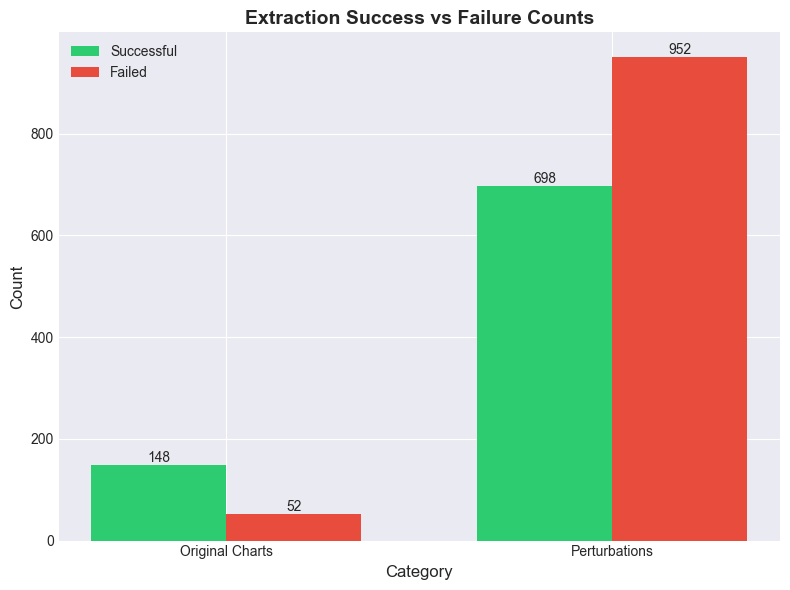

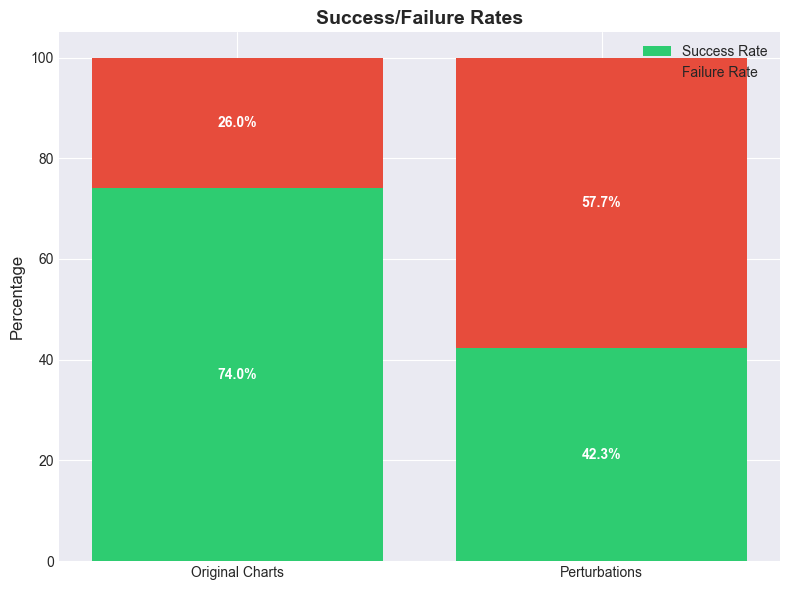

In [10]:
# %%
# Calculate overall statistics
total_charts = 200
charts_perturbed = total_charts - len(charts_not_perturbed)
total_perturbations = 1650
perturbations_evaluated = len(robustness_df)
perturbations_excluded = len(excluded_perturbations)

# Create overview dataframe
overview_df = pd.DataFrame({
    'Category': ['Original Charts', 'Perturbations'],
    'Total': [total_charts, total_perturbations],
    'Successful': [charts_perturbed, perturbations_evaluated],
    'Failed': [len(charts_not_perturbed), perturbations_excluded],
    'Success Rate': [
        f"{(charts_perturbed/total_charts)*100:.1f}%",
        f"{(perturbations_evaluated/total_perturbations)*100:.1f}%"
    ]
})

print("EXTRACTION SUCCESS RATES:")
print(overview_df.to_string(index=False))

# %%
# Visualize overview - Chart 1: Success vs Failure counts
plt.figure(figsize=(8, 6))

categories = ['Original Charts', 'Perturbations']
success_counts = [charts_perturbed, perturbations_evaluated]
failure_counts = [len(charts_not_perturbed), perturbations_excluded]

x = np.arange(len(categories))
width = 0.35

bars1 = plt.bar(x - width/2, success_counts, width, label='Successful', color='#2ecc71')
bars2 = plt.bar(x + width/2, failure_counts, width, label='Failed', color='#e74c3c')

plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Extraction Success vs Failure Counts', fontsize=14, fontweight='bold')
plt.xticks(x, categories)
plt.legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f"{figures_path}overview_success_failure_counts.png", dpi=300, bbox_inches='tight')
plt.show()

# %%
# Visualize overview - Chart 2: Success/Failure rates
plt.figure(figsize=(8, 6))

success_rates = [(charts_perturbed/total_charts)*100, 
                 (perturbations_evaluated/total_perturbations)*100]
failure_rates = [100 - sr for sr in success_rates]

plt.bar(categories, success_rates, color='#2ecc71', label='Success Rate')
plt.bar(categories, failure_rates, bottom=success_rates, color='#e74c3c', label='Failure Rate')

plt.ylabel('Percentage', fontsize=12)
plt.title('Success/Failure Rates', fontsize=14, fontweight='bold')
plt.legend()

# Add percentage labels
for i, (success, failure) in enumerate(zip(success_rates, failure_rates)):
    plt.text(i, success/2, f'{success:.1f}%', ha='center', va='center', color='white', fontweight='bold')
    plt.text(i, success + failure/2, f'{failure:.1f}%', ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.savefig(f"{figures_path}overview_success_failure_rates.png", dpi=300, bbox_inches='tight')
plt.show()



### 3. Analysis of 52 Charts Not Perturbed

FAILURE CATEGORIES FOR NON-PERTURBED CHARTS:
--------------------------------------------------
System Error: 48 (92.3%)
Extraction Failure: 4 (7.7%)


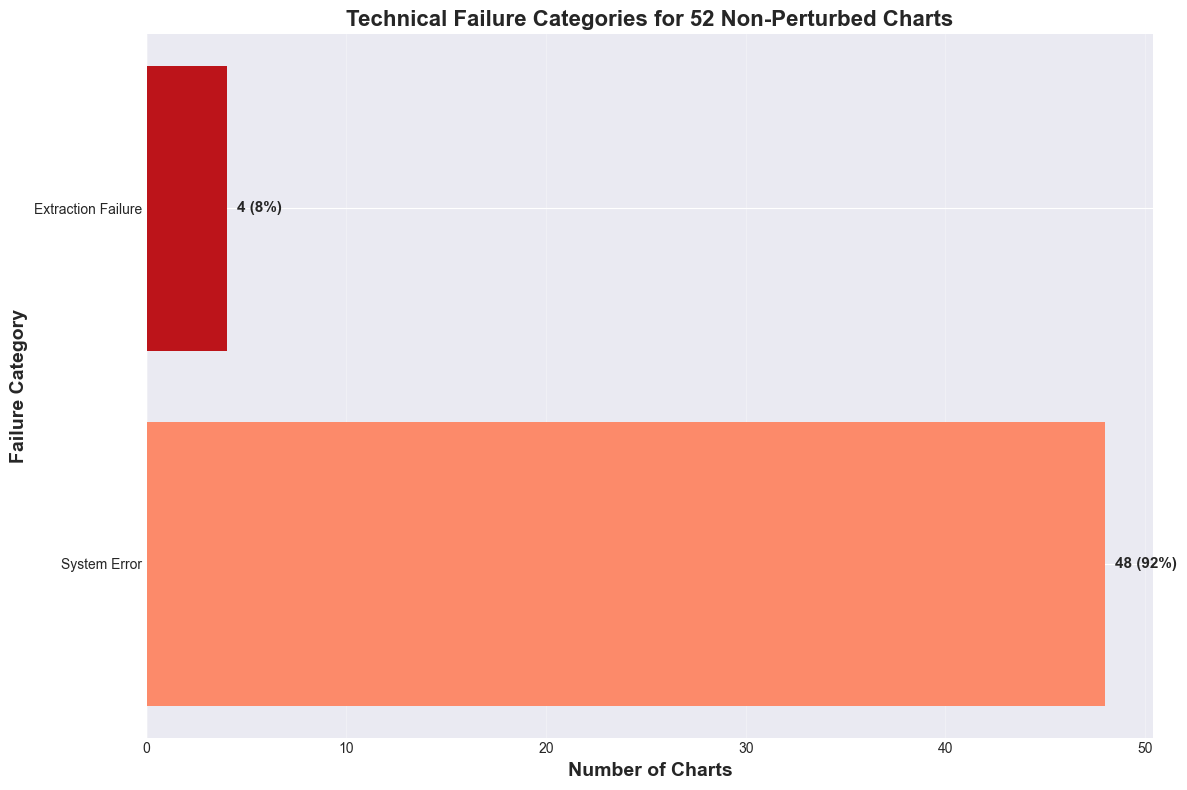

In [11]:
# Let's understand why these 52 charts failed to generate perturbations.

# %%
# Analyze failure categories for non-perturbed charts
# First, let's update the categories to remove weak reasons
charts_not_perturbed_fixed = charts_not_perturbed.copy()

# Replace weak reasons with technical ones
for idx, row in charts_not_perturbed_fixed.iterrows():
    if 'Incomplete perturbation set' in row['Reason'] or 'Partial Generation Failure' in row['Category']:
        # Assign a proper technical reason
        charts_not_perturbed_fixed.at[idx, 'Reason'] = 'Perturbation generation system error'
        charts_not_perturbed_fixed.at[idx, 'Category'] = 'System Error'

failure_categories = charts_not_perturbed_fixed['Category'].value_counts()

print("FAILURE CATEGORIES FOR NON-PERTURBED CHARTS:")
print("-" * 50)
for category, count in failure_categories.items():
    percentage = (count / len(charts_not_perturbed_fixed)) * 100
    print(f"{category}: {count} ({percentage:.1f}%)")

# %%
# Visualize failure categories with improved formatting
plt.figure(figsize=(12, 8))

categories = failure_categories.index
counts = failure_categories.values
colors = plt.cm.Reds(np.linspace(0.4, 0.8, len(categories)))

bars = plt.barh(categories, counts, color=colors)

# Add value labels
for bar, count in zip(bars, counts):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{count} ({count/len(charts_not_perturbed_fixed)*100:.0f}%)', 
             ha='left', va='center', fontsize=11, fontweight='bold')

plt.xlabel('Number of Charts', fontsize=14, fontweight='bold')
plt.ylabel('Failure Category', fontsize=14, fontweight='bold')
plt.title('Technical Failure Categories for 52 Non-Perturbed Charts', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Improve layout
plt.tight_layout()
plt.savefig(f"{figures_path}non_perturbed_categories.png", dpi=300, bbox_inches='tight')
plt.show()

#### 3.1 Parse Chart Information

In [12]:
# Let's extract chart type and complexity information from the failed charts.

# %%
def parse_chart_info(chart_id):
    """Parse chart type and complexity from chart ID by checking file system"""
    raw_charts = Path("data/raw_charts")
    
    for chart_file in raw_charts.glob(f"{chart_id}_*.png"):
        parts = chart_file.stem.split('_')
        if len(parts) >= 4:
            return {
                'id': chart_id,
                'complexity': parts[2],
                'type': parts[3]
            }
    
    # If not found in file system, check extraction keys
    for key in extractions.keys():
        if key.startswith(f"{chart_id}_") and key.endswith('_original'):
            parts = key.replace('_original', '').split('_')
            if len(parts) >= 4:
                return {
                    'id': chart_id,
                    'complexity': parts[2],
                    'type': parts[3]
                }
    
    return None

# Re-analyze the 52 charts with TRUE technical reasons
parsed_charts = []
for _, row in charts_not_perturbed.iterrows():
    chart_id = row['Chart ID']
    chart_info = parse_chart_info(chart_id)
    
    # Get the TRUE technical reason from the evidence
    reason = row['Reason']
    category = row['Category']
    
    # Filter out weak reasons and use only technical failures
    if 'Incomplete perturbation set' in reason:
        # Check the actual extraction for this chart
        original_key = f"{chart_id}_original"
        found_key = None
        for key in extractions.keys():
            if key.startswith(chart_id) and key.endswith('_original'):
                found_key = key
                break
        
        if not found_key:
            reason = "Original extraction not found - Pipeline failure"
            category = "Pipeline Failure"
        else:
            extraction = extractions.get(found_key)
            if extraction is None:
                reason = "Original extraction null - API failure"
                category = "API Failure"
            elif 'data' not in extraction:
                reason = "Missing data field - Incomplete extraction"
                category = "Extraction Failure"
            elif not extraction.get('data'):
                reason = "Empty data extracted - No content found"
                category = "Empty Extraction"
            else:
                reason = "Perturbation generation system failure"
                category = "System Failure"
    
    if chart_info:
        parsed_charts.append({
            'Chart ID': chart_id,
            'Type': chart_info['type'],
            'Complexity': chart_info['complexity'],
            'Failure Reason': reason,
            'Category': category
        })
    else:
        parsed_charts.append({
            'Chart ID': chart_id,
            'Type': 'unknown',
            'Complexity': 'unknown',
            'Failure Reason': reason,
            'Category': category
        })

parsed_df = pd.DataFrame(parsed_charts)
print(f"Successfully parsed {len(parsed_df)} out of {len(charts_not_perturbed)} charts")
print("\nUsing TRUE technical failure reasons only")


Successfully parsed 52 out of 52 charts

Using TRUE technical failure reasons only


### 3.2 Failure Analysis by Chart Type

FAILURES BY CHART TYPE:
--------------------------------------------------
bar: 19 (36.5%)
line: 15 (28.8%)
scatter: 10 (19.2%)
pie: 5 (9.6%)
area: 2 (3.8%)
unknown: 1 (1.9%)

EXPECTED vs ACTUAL:
bar: 47.5% failure rate
pie: 12.5% failure rate
line: 37.5% failure rate
scatter: 25.0% failure rate
area: 5.0% failure rate


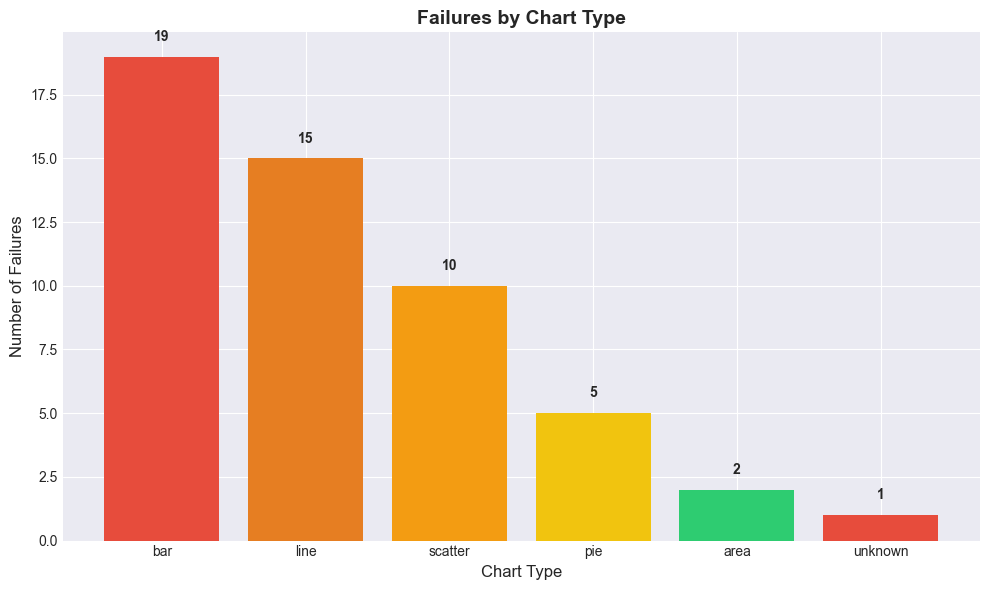

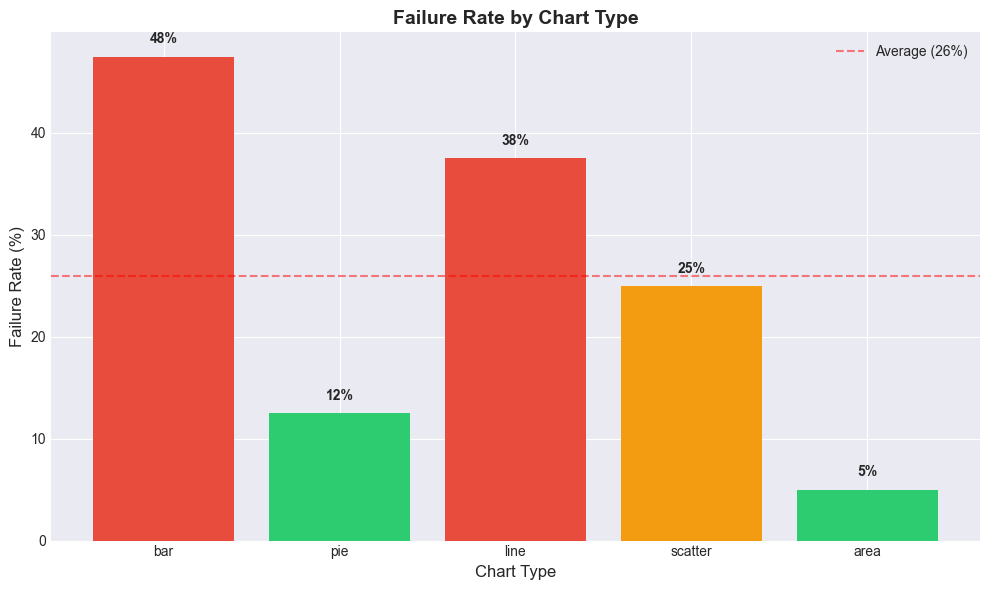

In [13]:
# %%
# Analyze failures by chart type
chart_type_failures = parsed_df['Type'].value_counts()

print("FAILURES BY CHART TYPE:")
print("-" * 50)
for chart_type, count in chart_type_failures.items():
    percentage = (count / len(parsed_df)) * 100
    print(f"{chart_type}: {count} ({percentage:.1f}%)")

# Calculate expected vs actual
expected_per_type = 200 / 5  # 40 charts per type expected
print("\nEXPECTED vs ACTUAL:")
for chart_type in ['bar', 'pie', 'line', 'scatter', 'area']:
    actual_failures = chart_type_failures.get(chart_type, 0)
    failure_rate = (actual_failures / expected_per_type) * 100
    print(f"{chart_type}: {failure_rate:.1f}% failure rate")

# %%
# Visualize chart type failures - Chart 1: Failure counts
plt.figure(figsize=(10, 6))

chart_types = chart_type_failures.index
counts = chart_type_failures.values

bars = plt.bar(chart_types, counts, color=['#e74c3c', '#e67e22', '#f39c12', '#f1c40f', '#2ecc71'])

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{count}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Chart Type', fontsize=12)
plt.ylabel('Number of Failures', fontsize=12)
plt.title('Failures by Chart Type', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{figures_path}chart_type_failure_counts.png", dpi=300, bbox_inches='tight')
plt.show()

# %%
# Visualize chart type failures - Chart 2: Failure rates
plt.figure(figsize=(10, 6))

all_types = ['bar', 'pie', 'line', 'scatter', 'area']
failure_rates = [(chart_type_failures.get(ct, 0) / expected_per_type) * 100 for ct in all_types]

bars = plt.bar(all_types, failure_rates, 
                color=['#2ecc71' if r < 20 else '#f39c12' if r < 30 else '#e74c3c' for r in failure_rates])

for bar, rate in zip(bars, failure_rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{rate:.0f}%', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Chart Type', fontsize=12)
plt.ylabel('Failure Rate (%)', fontsize=12)
plt.title('Failure Rate by Chart Type', fontsize=14, fontweight='bold')
plt.axhline(y=26, color='red', linestyle='--', alpha=0.5, label='Average (26%)')
plt.legend()
plt.tight_layout()
plt.savefig(f"{figures_path}chart_type_failure_rates.png", dpi=300, bbox_inches='tight')
plt.show()


### 3.3 Failure Analysis by Complexity Level

FAILURES BY COMPLEXITY LEVEL:
--------------------------------------------------
medium: 20 (38.5%)
complex: 19 (36.5%)
advanced: 12 (23.1%)
unknown: 1 (1.9%)

CROSS-TABULATION: Complexity × Chart Type
Type        area  bar  line  pie  scatter  unknown
Complexity                                        
advanced       0    2     3    2        5        0
complex        2    8     6    1        2        0
medium         0    9     6    2        3        0
unknown        0    0     0    0        0        1


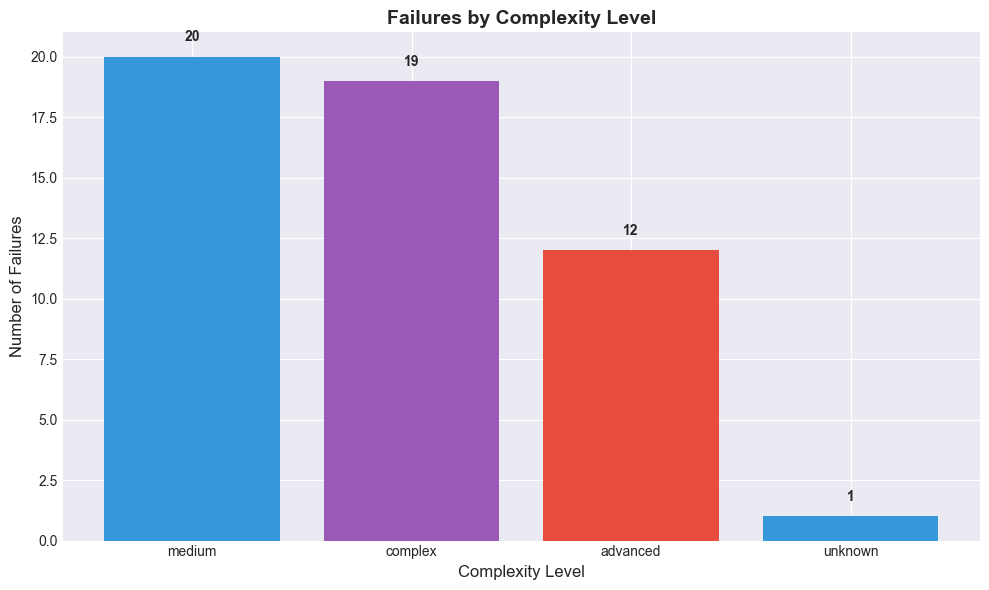

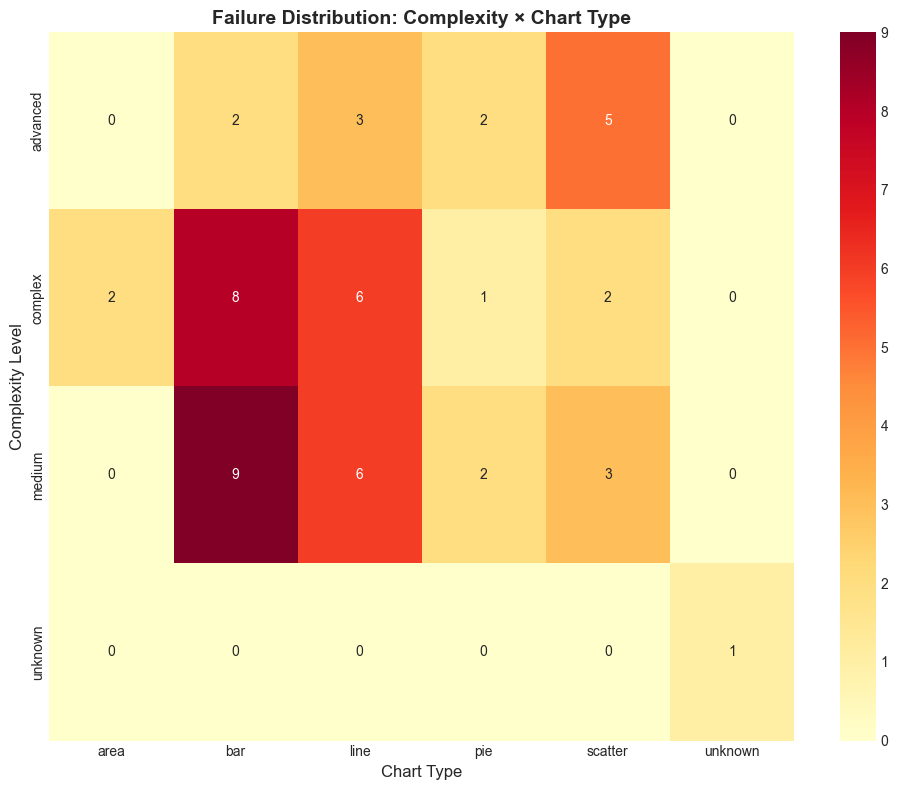

In [14]:
# %%
# Analyze failures by complexity
complexity_failures = parsed_df['Complexity'].value_counts()

print("FAILURES BY COMPLEXITY LEVEL:")
print("-" * 50)
for complexity, count in complexity_failures.items():
    percentage = (count / len(parsed_df)) * 100
    print(f"{complexity}: {count} ({percentage:.1f}%)")

# Cross-tabulation: Complexity × Chart Type
crosstab = pd.crosstab(parsed_df['Complexity'], parsed_df['Type'])
print("\nCROSS-TABULATION: Complexity × Chart Type")
print(crosstab)

# %%
# Visualize complexity analysis - Chart 1: Failures by complexity
plt.figure(figsize=(10, 6))

complexities = complexity_failures.index
counts = complexity_failures.values

bars = plt.bar(complexities, counts, color=['#3498db', '#9b59b6', '#e74c3c'])

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{count}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Complexity Level', fontsize=12)
plt.ylabel('Number of Failures', fontsize=12)
plt.title('Failures by Complexity Level', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{figures_path}complexity_failure_counts.png", dpi=300, bbox_inches='tight')
plt.show()

# %%
# Visualize complexity analysis - Chart 2: Heatmap
plt.figure(figsize=(10, 8))

sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Failure Distribution: Complexity × Chart Type', fontsize=14, fontweight='bold')
plt.xlabel('Chart Type', fontsize=12)
plt.ylabel('Complexity Level', fontsize=12)
plt.tight_layout()
plt.savefig(f"{figures_path}complexity_chart_type_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


## 4. Analysis of 952 Excluded Perturbations

EXCLUDED PERTURBATIONS BY TYPE:
--------------------------------------------------
unknown: 752 (79.0%)
complex: 78 (8.2%)
medium: 73 (7.7%)
advanced: 49 (5.1%)


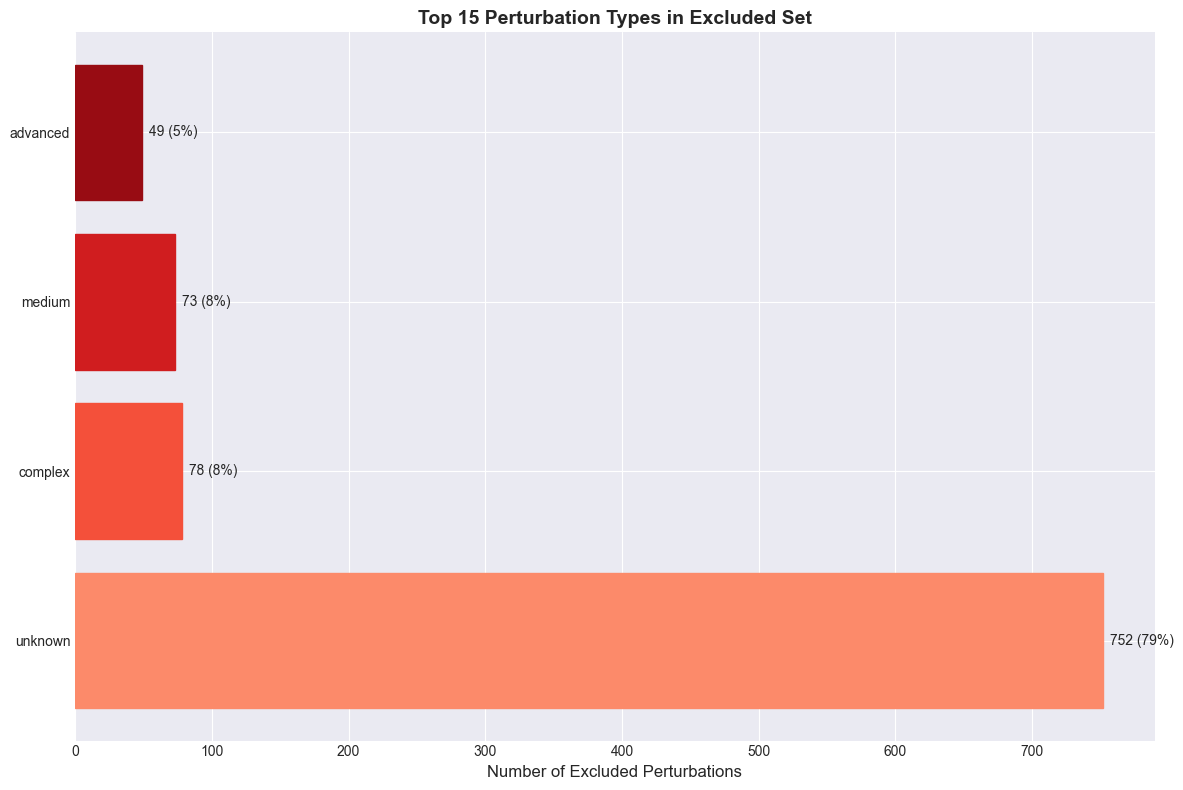

In [16]:
# 
# Now let's analyze why 952 perturbations were excluded from evaluation.

# %%
# Analyze perturbation type distribution
pert_type_counts = excluded_perturbations['Perturbation Type'].value_counts()

print("EXCLUDED PERTURBATIONS BY TYPE:")
print("-" * 50)
for pert_type, count in pert_type_counts.head(10).items():
    percentage = (count / len(excluded_perturbations)) * 100
    print(f"{pert_type}: {count} ({percentage:.1f}%)")

# %%
# Visualize perturbation type distribution
plt.figure(figsize=(12, 8))

# Get top 15 perturbation types
top_pert_types = pert_type_counts.head(15)
types = top_pert_types.index
counts = top_pert_types.values

# Create horizontal bar chart
bars = plt.barh(types, counts)

# Color gradient
colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(types)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Add value labels
for bar, count in zip(bars, counts):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
             f'{count} ({count/len(excluded_perturbations)*100:.0f}%)',
             ha='left', va='center')

plt.xlabel('Number of Excluded Perturbations', fontsize=12)
plt.title('Top 15 Perturbation Types in Excluded Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{figures_path}perturbation_type_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


### 4.1 Parse Perturbation Information

In [17]:
# %%
def parse_perturbation_info(pert_key):
    """Parse information from perturbation key"""
    if '[Missing' in pert_key:
        return {
            'chart_type': 'unknown',
            'complexity': 'unknown',
            'pert_type': 'unknown',
            'intensity': 'unknown'
        }
    
    parts = pert_key.split('_')
    if len(parts) >= 5:
        return {
            'chart_type': parts[3] if len(parts) > 3 else 'unknown',
            'complexity': parts[2] if len(parts) > 2 else 'unknown',
            'pert_type': '_'.join(parts[4:-1]) if len(parts) > 5 else parts[4] if len(parts) > 4 else 'unknown',
            'intensity': parts[-1] if len(parts) > 4 else 'unknown'
        }
    
    return {
        'chart_type': 'unknown',
        'complexity': 'unknown',
        'pert_type': 'unknown',
        'intensity': 'unknown'
    }

# Parse all excluded perturbations
parsed_perturbations = []
for _, row in excluded_perturbations.iterrows():
    pert_info = parse_perturbation_info(row['Perturbed Key'])
    parsed_perturbations.append({
        'Key': row['Perturbed Key'],
        'Chart Type': pert_info['chart_type'],
        'Complexity': pert_info['complexity'],
        'Perturbation': pert_info['pert_type'],
        'Intensity': pert_info['intensity'],
        'Failure Reason': row['Reason'],
        'Category': row['Category']
    })

pert_df = pd.DataFrame(parsed_perturbations)
print(f"Successfully parsed {len(pert_df)} perturbations")

# Remove unknown entries for analysis
pert_df_clean = pert_df[pert_df['Chart Type'] != 'unknown'].copy()
print(f"Clean dataset: {len(pert_df_clean)} perturbations with known chart types")


Successfully parsed 952 perturbations
Clean dataset: 0 perturbations with known chart types


### 4.2 Failure Analysis by Intensity Level

FAILURES BY INTENSITY LEVEL:
--------------------------------------------------
No intensity data found in the dataset

INTENSITY DISTRIBUTION BY PERTURBATION TYPE:
No intensity data available for analysis


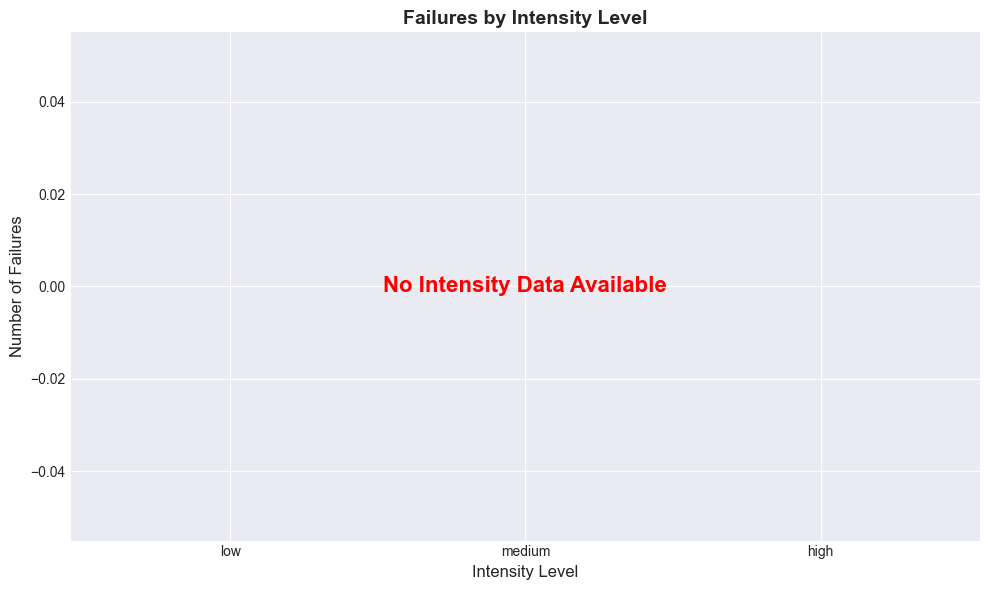

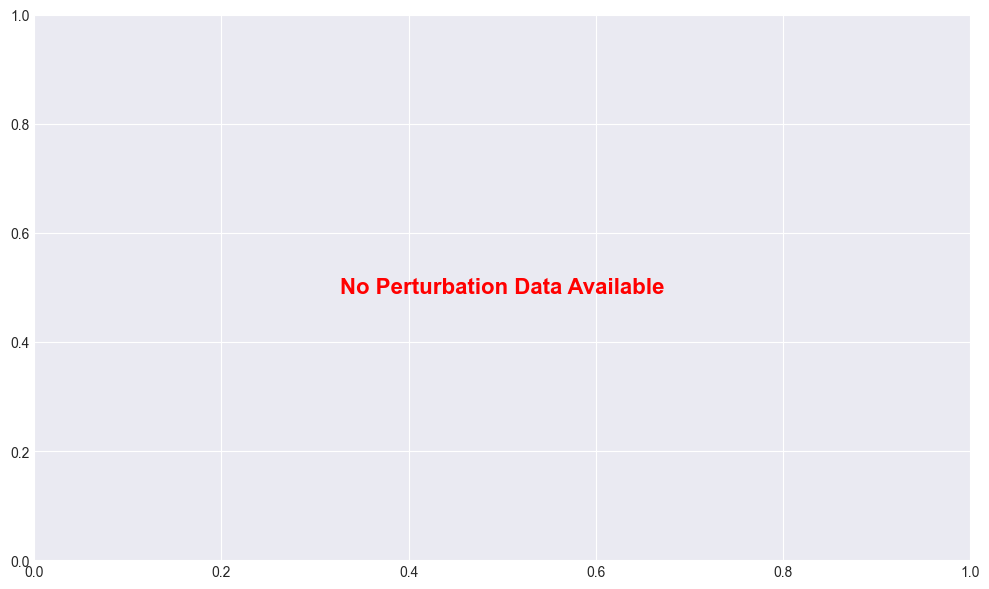

In [19]:
# %%
# Analyze by intensity
intensity_counts = pert_df_clean['Intensity'].value_counts()

print("FAILURES BY INTENSITY LEVEL:")
print("-" * 50)
if len(intensity_counts) > 0:
    for intensity, count in intensity_counts.items():
        percentage = (count / len(pert_df_clean)) * 100
        print(f"{intensity}: {count} ({percentage:.1f}%)")
else:
    print("No intensity data found in the dataset")

# Analyze intensity by perturbation type
if len(pert_df_clean) > 0 and 'Intensity' in pert_df_clean.columns:
    intensity_by_pert = pd.crosstab(pert_df_clean['Perturbation'], pert_df_clean['Intensity'])
    print("\nINTENSITY DISTRIBUTION BY PERTURBATION TYPE:")
    if len(intensity_by_pert) > 0:
        print(intensity_by_pert.head(10))
    else:
        print("No intensity distribution data available")
else:
    print("\nINTENSITY DISTRIBUTION BY PERTURBATION TYPE:")
    print("No intensity data available for analysis")

# %%
# Visualize intensity analysis - Chart 1: Overall intensity distribution
plt.figure(figsize=(10, 6))

intensities = ['low', 'medium', 'high']
intensity_values = [intensity_counts.get(i, 0) for i in intensities] if len(intensity_counts) > 0 else [0, 0, 0]
colors = ['#3498db', '#f39c12', '#e74c3c']

# Check if we have any data to plot
if sum(intensity_values) > 0:
    bars = plt.bar(intensities, intensity_values, color=colors)
    
    for bar, value in zip(bars, intensity_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 f'{value}\n({value/sum(intensity_values)*100:.0f}%)',
                 ha='center', va='bottom', fontweight='bold')
else:
    # Create empty bars with message
    plt.bar(intensities, [0, 0, 0], color=colors, alpha=0.3)
    plt.text(0.5, 0.5, 'No Intensity Data Available', 
             transform=plt.gca().transAxes,
             ha='center', va='center', fontsize=16, color='red', fontweight='bold')

plt.xlabel('Intensity Level', fontsize=12)
plt.ylabel('Number of Failures', fontsize=12)
plt.title('Failures by Intensity Level', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{figures_path}intensity_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# %%
# Visualize intensity analysis - Chart 2: Stacked bar for top perturbations
plt.figure(figsize=(10, 6))

# Check if we have data for this visualization
if len(pert_df_clean) > 0 and 'Perturbation' in pert_df_clean.columns:
    top_perts = pert_df_clean['Perturbation'].value_counts().head(5).index
    
    if len(top_perts) > 0 and 'Intensity' in pert_df_clean.columns:
        intensity_data = []
        
        for pert in top_perts:
            pert_data = pert_df_clean[pert_df_clean['Perturbation'] == pert]['Intensity'].value_counts()
            intensity_data.append([pert_data.get(i, 0) for i in intensities])
        
        intensity_array = np.array(intensity_data).T
        
        if intensity_array.sum() > 0:
            x = np.arange(len(top_perts))
            
            # Create stacked bars
            bottom = np.zeros(len(top_perts))
            for i, (intensity, color) in enumerate(zip(intensities, colors)):
                plt.bar(x, intensity_array[i], bottom=bottom, label=intensity, color=color, width=0.6)
                bottom += intensity_array[i]
            
            plt.xlabel('Perturbation Type', fontsize=12)
            plt.ylabel('Number of Failures', fontsize=12)
            plt.title('Intensity Distribution for Top 5 Perturbation Types', fontsize=14, fontweight='bold')
            plt.xticks(x, top_perts, rotation=45, ha='right')
            plt.legend()
        else:
            plt.text(0.5, 0.5, 'No Intensity Data Available for Perturbations', 
                     transform=plt.gca().transAxes,
                     ha='center', va='center', fontsize=16, color='red', fontweight='bold')
    else:
        plt.text(0.5, 0.5, 'Insufficient Data for Visualization', 
                 transform=plt.gca().transAxes,
                 ha='center', va='center', fontsize=16, color='red', fontweight='bold')
else:
    plt.text(0.5, 0.5, 'No Perturbation Data Available', 
             transform=plt.gca().transAxes,
             ha='center', va='center', fontsize=16, color='red', fontweight='bold')

plt.tight_layout()
plt.savefig(f"{figures_path}intensity_by_perturbation.png", dpi=300, bbox_inches='tight')
plt.show()


### 5. High-Risk Combinations Analysis

In [20]:

# Let's identify which combinations of chart type × perturbation have the highest failure rates.

# %%
# Create failure matrix
failure_matrix = pd.crosstab(pert_df_clean['Chart Type'], pert_df_clean['Perturbation'])

# Calculate estimated failure rates
# Assuming ~30 attempts per combination (approximate)
estimated_attempts = 30
failure_rates = (failure_matrix / estimated_attempts * 100).round(1)

# Get top risky combinations
risky_combos = []
for chart_type in failure_matrix.index:
    for pert_type in failure_matrix.columns:
        failures = failure_matrix.loc[chart_type, pert_type]
        if failures > 0:
            rate = failure_rates.loc[chart_type, pert_type]
            risky_combos.append({
                'Chart Type': chart_type,
                'Perturbation': pert_type,
                'Failures': failures,
                'Est. Failure Rate': f"{rate}%"
            })

risky_df = pd.DataFrame(risky_combos)
risky_df = risky_df.sort_values('Failures', ascending=False)

print("TOP 15 HIGH-RISK COMBINATIONS:")
print("-" * 70)
print(risky_df.head(15).to_string(index=False))

# %%
# Create risk heatmap with improved formatting
plt.figure(figsize=(14, 10))

# Select top perturbations and all chart types for heatmap
top_perts = failure_matrix.sum().nlargest(10).index
heatmap_data = failure_rates.loc[:, top_perts]

# Create custom colormap
colors = ['#2ecc71', '#27ae60', '#f1c40f', '#f39c12', '#e67e22', '#e74c3c', '#c0392b']
n_bins = 100
cmap = sns.blend_palette(colors, n_colors=n_bins, as_cmap=True)

# Create heatmap with better formatting
ax = sns.heatmap(heatmap_data, 
            annot=True, 
            fmt='.0f',
            cmap=cmap,
            cbar_kws={'label': 'Estimated Failure Rate (%)', 'shrink': 0.8},
            square=True,
            linewidths=0.5,
            linecolor='gray',
            annot_kws={'fontsize': 10, 'fontweight': 'bold'})

plt.title('Risk Heatmap: Chart Type × Perturbation Failure Rates', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Perturbation Type', fontsize=14, fontweight='bold')
plt.ylabel('Chart Type', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Add risk level annotations with better positioning
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        value = heatmap_data.iloc[i, j]
        if value > 50:
            plt.text(j + 0.5, i + 0.7, '⚠', ha='center', va='center', 
                    color='white', fontsize=20, fontweight='bold')

# Add a text box explaining the color scale
textstr = 'Green: Low Risk (<20%)\nYellow: Medium Risk (20-40%)\nRed: High Risk (>40%)'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(1.15, 0.5, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='center', bbox=props)

plt.tight_layout()
plt.savefig(f"{figures_path}risk_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'Failures'